# Imports


In [ ]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import torchvision
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

# Import tf and keras for potential usage
import tensorflow as tf
import keras
from tqdm import tqdm
from torch.autograd import Variable

# Import time
import time

# Import matplotlib for plotting
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

# Helper Functions

## Set Global Values

In [ ]:
# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = False

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define relevant variables for the ML task
batch_size = 32
num_classes = 10
learning_rate = 0.001
num_epochs = 10
seed = 413
torch.manual_seed(seed)

## Functions

In [ ]:
# Referenced from csc413/a2
# https://uoft-csc413.github.io/2023/assets/assignments/a2.pdf

######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/csc413/final
%cd /content/csc413/final

######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :]
        yield (batch_x, batch_y)


def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def get_torch_vars2(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


/content/csc413/final


In [ ]:
def format_result(train_loss, eval_acc, eval_loss):

  tr_loss = []
  acc = []
  ev_loss = []

  for loss in train_loss:

    tr_loss.append(loss.item())
  
  for accuracy in eval_acc:

    acc.append(accuracy.item())
  
  new_acc = [i/100 for i in acc]

  for loss in eval_loss:

    ev_loss.append(loss.item())
  
  epoch = [i for i in range(1, num_epochs + 1)]

  dic = {'epoch': epoch, 'training loss': tr_loss, 'eval accuracy': new_acc, 'eval loss': ev_loss}
  return dic

# LeNet

## TODO



Add test code on validation dataset

## Define LeNet

In [ ]:
class LeNet5(nn.Module):
    """
    A class defining a Convolutional Neural Network model for image classification.

    Args:
        num_classes (int): Number of classes for classification.

    Attributes:
        layer1 (nn.Sequential): First convolutional layer, consisting of a 2D convolutional operation, 
            batch normalization, ReLU activation function, and max pooling operation.
        layer2 (nn.Sequential): Second convolutional layer, consisting of a 2D convolutional operation, 
            batch normalization, ReLU activation function, and max pooling operation.
        fc (nn.Linear): Fully connected layer with 120 output units.
        relu (nn.ReLU): ReLU activation function.
        fc1 (nn.Linear): Fully connected layer with 84 output units.
        relu1 (nn.ReLU): ReLU activation function.
        fc2 (nn.Linear): Fully connected layer with num_classes output units.

    Methods:
        forward(x): Performs forward pass of the input through the layers of the network.

    """
    def __init__(self, num_classes, grayscale=False):
        """
        Initializes the LeNet5 model.

        Args:
            num_classes (int): Number of classes for classification.
        """
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.layer1 = nn.Sequential(
            nn.Conv2d(1*in_channels, 6*in_channels, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6*in_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16*in_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400*in_channels, 120*in_channels)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120*in_channels, 84*in_channels)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84*in_channels, num_classes)
        
    def forward(self, x):
        """
        Performs forward pass of the input through the layers of the network.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, channels, height, width].

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, num_classes].
        """
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

## LeNet Training Functions

In [ ]:
def compute_accuracy(model, data_loader, device):
    """ Return the evaluation accuracy and loss
    """
    correct_pred, num_examples = 0, 0
    losses = []
    for features, targets in tqdm(data_loader, desc="Evaluation"):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        #targets = get_torch_vars2(features, targets, gpu=True if device==torch.device('cuda') else False)

        out = model(features)
        losses.append(F.cross_entropy(out, targets))
        probas = F.softmax(out, dim=1)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, torch.mean(torch.tensor(losses))
    

def train(model):
  """ Return losses and validation accuracies for every epoch (for plotting)
  """
  train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

  test_dataset = datasets.CIFAR10(root='data', 
                                  train=False, 
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            num_workers=2,
                            shuffle=True)

  test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=False)
  start_time = time.time()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

  train_loss = []
  eval_acc = []
  eval_loss = []
  for epoch in range(NUM_EPOCHS):
      
      model.train()
      loss_epoch = []
      for features, targets in tqdm(train_loader, desc="Training"):
          
          # features, targets = get_torch_vars2(features, targets, gpu=True if device==torch.device('cuda') else False)
          features = features.to(DEVICE)
          targets = targets.to(DEVICE)
              
          ### FORWARD AND BACK PROP
          out = model(features)
          probas = F.softmax(out, dim=1)
          loss = F.cross_entropy(out, targets)
          loss_epoch.append(loss)
          optimizer.zero_grad()
          
          loss.backward()
          
          ### UPDATE MODEL PARAMETERS
          optimizer.step()
          
      ### LOGGING
      avg_loss_epoch = torch.mean(torch.tensor(loss_epoch))
      train_loss.append(avg_loss_epoch)
      print('Epoch: %03d/%03d | Train Loss: %.4f' 
              %(epoch+1, NUM_EPOCHS, avg_loss_epoch))

          

      model.eval()
      with torch.set_grad_enabled(False): # save memory during inference
          acc, loss = compute_accuracy(model, test_loader, device=DEVICE)
      eval_acc.append(acc)
      eval_loss.append(loss)
      print('Epoch: %03d/%03d | Eval Acc: %.3f%% | Eval Loss: %.4f' % (
              epoch+1, NUM_EPOCHS, acc, loss))
          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
      
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  # SAVE MODEL
  torch.save(model.state_dict(), 'data/lenet_model')

  return train_loss, eval_acc, eval_loss

# AlexNet

https://www.researchgate.net/figure/Classical-CNN-Architectures-LeNet-and-AlexNet-used-to-outperform-the-state-of-the-art_fig1_351333148

We defined the code for **AlexNet** as below. The model is a convolutional neural network and takes 3-channel input images. The model architecture consists of 5 convolutional layers and 3 fully connected layers.

The first convolutional layer has 96 output channels and a kernel size of 11x11 with a stride of 4 and no padding. This is followed by batch normalization, ReLU activation, and max-pooling with a kernel size of 3x3 and a stride of 2.

The second convolutional layer has 256 output channels and a kernel size of 5x5 with a stride of 1 and padding of 2. This is also followed by batch normalization, ReLU activation, and max-pooling with a kernel size of 3x3 and a stride of 2.

The third, fourth, and fifth convolutional layers have 384, 384, and 256 output channels, respectively. They all have a kernel size of 3x3 with a stride of 1 and padding of 1, and are followed by batch normalization and ReLU activation. The fifth convolutional layer is followed by max-pooling with a kernel size of 3x3 and a stride of 2.

The flattened output from the fifth convolutional layer is fed into two fully connected layers with 4096 output units each, followed by ReLU activation and dropout regularization with a probability of 0.5. The final fully connected layer has a number of output units equal to the number of classes in the dataset, which is specified as an argument to the constructor.

## TODO



Add test code on validation dataset

## Define AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        """
        AlexNet model constructor. 
        Similar methodolgy as LeNet-5, with different layer settings.

        Parameters:
            num_classes (int): Number of classes in the dataset.
                                Default value is 10.
        """
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        """
        Performs forward pass of the input through the layers of the network.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, channels, height, width].

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, num_classes].
        """
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## AlexNet Training Functions

It is important to notice that we need to rescale the image back to 227x227 for AlexNet to successfully proceed, following the tutorial on the [PyTorch documentation of training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html):  we are able to do it in the simplest way - download the dataset again and scale again.

The dataset size is not too large, and won't cause problem in this approach, however, if we consider expanding our dataset or using any other dataset, we may need to consider scaling on the dataset only to avoid the extra cost of downloading the data.

In [ ]:
def get_AlexNet_data():
  """
    Reshape AlexNet data, the size should be 227 x 227
  """
  normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
  )

  # define transform
  transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize,
  ])

  train_dataset = datasets.CIFAR10(root='data', 
                                  train=True, 
                                  transform=transform,
                                  download=True)

  test_dataset = datasets.CIFAR10(root='data', 
                                  train=False, 
                                  transform=transform)

  train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            num_workers=2,
                            shuffle=True)

  test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=False)
  return (train_dataset, test_dataset, train_loader, test_loader)

(train_dataset_alex, test_dataset_alex, train_loader_alex, test_loader_alex) = get_AlexNet_data()

def train_alexnet(model):
  """ Return the train loss, evaluation accuracy and evaluation loss per epoch (for plotting)
  """
  start_time = time.time()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

  train_loss = []
  eval_acc = []
  eval_loss = []
  for epoch in range(NUM_EPOCHS):
      
      model.train()
      epoch_losses = []
      for features, targets in tqdm(train_loader_alex, desc="Training"):
          
          # features, targets = get_torch_vars2(features, targets, gpu=True if device==torch.device('cuda') else False)
          features = features.to(DEVICE)
          targets = targets.to(DEVICE)
              
          ### FORWARD AND BACK PROP
          out = model(features)
          probas = F.softmax(out, dim=1)
          loss = F.cross_entropy(out, targets)
          epoch_losses.append(loss)
          optimizer.zero_grad()
          
          loss.backward()
          
          ### UPDATE MODEL PARAMETERS
          optimizer.step()
          
      ### LOGGING
      loss_epoch = torch.mean(torch.tensor(epoch_losses))
      train_loss.append(loss_epoch)
      print ('Epoch: %03d/%03d | Cost: %.4f' 
                %(epoch+1, NUM_EPOCHS, loss_epoch))
          

      model.eval()
      with torch.set_grad_enabled(False): # save memory during inference
          acc, loss = compute_accuracy(model, test_loader_alex, device=DEVICE)
      eval_acc.append(acc)
      eval_loss.append(loss)
      print('Epoch: %03d/%03d | Eval Acc: %.3f%% | Eval Loss: %.4f' % (
              epoch+1, NUM_EPOCHS, acc, loss))
          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
      
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  torch.save(model.state_dict(), 'data/alexnet_model')
  
  return train_loss, eval_acc, eval_loss

100%|██████████| 170498071/170498071 [00:02<00:00, 74195772.30it/s]


Extracting data/cifar-10-python.tar.gz to data


# Compare LeNet vs. AlexNet

TODO: plotting of performance (LeNet vs AlexNet)

We expect to see AlexNet converge faster and converge to a higher accuracy than LeNet.

What we actually see: ___

## Hyperparameters

In [ ]:
# Hyperparameters
RANDOM_SEED = 413
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 10

## Training LeNet

Only need to run once, use load models afterwards

In [ ]:
model1 = LeNet5(NUM_CLASSES)
model1.to(DEVICE)
train_loss_lenet, eval_acc_lenet, eval_loss_lenet = train(model1)

Files already downloaded and verified


Training: 100%|██████████| 1563/1563 [00:22<00:00, 69.40it/s] 


Epoch: 001/010 | Train Loss: 1.3481


Evaluation: 100%|██████████| 313/313 [00:02<00:00, 124.86it/s]


Epoch: 001/010 | Eval Acc: 52.810% | Eval Loss: 1.3305
Time elapsed: 0.42 min


Training: 100%|██████████| 1563/1563 [00:16<00:00, 94.31it/s]


Epoch: 002/010 | Train Loss: 1.0224


Evaluation: 100%|██████████| 313/313 [00:02<00:00, 120.83it/s]


Epoch: 002/010 | Eval Acc: 58.240% | Eval Loss: 1.1950
Time elapsed: 0.74 min


Training: 100%|██████████| 1563/1563 [00:20<00:00, 76.67it/s]


Epoch: 003/010 | Train Loss: 0.8653


Evaluation: 100%|██████████| 313/313 [00:05<00:00, 60.25it/s]


Epoch: 003/010 | Eval Acc: 68.230% | Eval Loss: 0.9106
Time elapsed: 1.17 min


Training: 100%|██████████| 1563/1563 [00:21<00:00, 73.55it/s]


Epoch: 004/010 | Train Loss: 0.7613


Evaluation: 100%|██████████| 313/313 [00:03<00:00, 90.64it/s] 


Epoch: 004/010 | Eval Acc: 70.110% | Eval Loss: 0.8743
Time elapsed: 1.58 min


Training: 100%|██████████| 1563/1563 [00:15<00:00, 98.67it/s] 


Epoch: 005/010 | Train Loss: 0.6785


Evaluation: 100%|██████████| 313/313 [00:02<00:00, 124.16it/s]


Epoch: 005/010 | Eval Acc: 67.940% | Eval Loss: 0.9385
Time elapsed: 1.89 min


Training: 100%|██████████| 1563/1563 [00:15<00:00, 98.69it/s] 


Epoch: 006/010 | Train Loss: 0.6029


Evaluation: 100%|██████████| 313/313 [00:03<00:00, 89.66it/s] 


Epoch: 006/010 | Eval Acc: 68.530% | Eval Loss: 0.9491
Time elapsed: 2.21 min


Training: 100%|██████████| 1563/1563 [00:16<00:00, 97.51it/s] 


Epoch: 007/010 | Train Loss: 0.5430


Evaluation: 100%|██████████| 313/313 [00:02<00:00, 120.79it/s]


Epoch: 007/010 | Eval Acc: 72.720% | Eval Loss: 0.8296
Time elapsed: 2.52 min


Training: 100%|██████████| 1563/1563 [00:16<00:00, 96.89it/s] 


Epoch: 008/010 | Train Loss: 0.4828


Evaluation: 100%|██████████| 313/313 [00:03<00:00, 89.16it/s] 


Epoch: 008/010 | Eval Acc: 72.310% | Eval Loss: 0.8478
Time elapsed: 2.85 min


Training: 100%|██████████| 1563/1563 [00:17<00:00, 90.98it/s] 


Epoch: 009/010 | Train Loss: 0.4261


Evaluation: 100%|██████████| 313/313 [00:02<00:00, 122.35it/s]


Epoch: 009/010 | Eval Acc: 73.050% | Eval Loss: 0.8628
Time elapsed: 3.18 min


Training: 100%|██████████| 1563/1563 [00:16<00:00, 94.78it/s]


Epoch: 010/010 | Train Loss: 0.3778


Evaluation: 100%|██████████| 313/313 [00:02<00:00, 108.56it/s]

Epoch: 010/010 | Eval Acc: 69.840% | Eval Loss: 1.0438
Time elapsed: 3.51 min
Total Training Time: 3.51 min


## Training AlexNet

Only need to run once, use load models afterwards

In [ ]:
model2 = AlexNet(NUM_CLASSES)
model2.to(DEVICE)
train_loss_alex, eval_acc_alex, eval_loss_alex = train_alexnet(model2)

Training: 100%|██████████| 1563/1563 [01:45<00:00, 14.79it/s]


Epoch: 001/010 | Cost: 1.9802


Evaluation: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s]


Epoch: 001/010 | Eval Acc: 37.750% | Eval Loss: 1.6730
Time elapsed: 2.06 min


Training: 100%|██████████| 1563/1563 [01:47<00:00, 14.56it/s]


Epoch: 002/010 | Cost: 1.6009


Evaluation: 100%|██████████| 313/313 [00:18<00:00, 16.59it/s]


Epoch: 002/010 | Eval Acc: 52.290% | Eval Loss: 1.3962
Time elapsed: 4.16 min


Training: 100%|██████████| 1563/1563 [01:47<00:00, 14.58it/s]


Epoch: 003/010 | Cost: 1.3200


Evaluation: 100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


Epoch: 003/010 | Eval Acc: 57.120% | Eval Loss: 1.2168
Time elapsed: 6.27 min


Training: 100%|██████████| 1563/1563 [01:45<00:00, 14.82it/s]


Epoch: 004/010 | Cost: 1.0878


Evaluation: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s]


Epoch: 004/010 | Eval Acc: 67.910% | Eval Loss: 0.9612
Time elapsed: 8.33 min


Training: 100%|██████████| 1563/1563 [02:04<00:00, 12.52it/s]


Epoch: 005/010 | Cost: 0.9139


Evaluation: 100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


Epoch: 005/010 | Eval Acc: 71.580% | Eval Loss: 0.8223
Time elapsed: 10.74 min


Training: 100%|██████████| 1563/1563 [01:47<00:00, 14.48it/s]


Epoch: 006/010 | Cost: 0.7879


Evaluation: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s]


Epoch: 006/010 | Eval Acc: 76.020% | Eval Loss: 0.7104
Time elapsed: 12.84 min


Training: 100%|██████████| 1563/1563 [01:48<00:00, 14.40it/s]


Epoch: 007/010 | Cost: 0.7042


Evaluation: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s]


Epoch: 007/010 | Eval Acc: 78.530% | Eval Loss: 0.6481
Time elapsed: 14.95 min


Training: 100%|██████████| 1563/1563 [01:45<00:00, 14.87it/s]


Epoch: 008/010 | Cost: 0.6295


Evaluation: 100%|██████████| 313/313 [00:18<00:00, 16.88it/s]


Epoch: 008/010 | Eval Acc: 78.420% | Eval Loss: 0.6202
Time elapsed: 17.01 min


Training: 100%|██████████| 1563/1563 [01:44<00:00, 14.97it/s]


Epoch: 009/010 | Cost: 0.5702


Evaluation: 100%|██████████| 313/313 [00:18<00:00, 17.02it/s]


Epoch: 009/010 | Eval Acc: 81.250% | Eval Loss: 0.5642
Time elapsed: 19.06 min


Training: 100%|██████████| 1563/1563 [01:43<00:00, 15.08it/s]


Epoch: 010/010 | Cost: 0.5172


Evaluation: 100%|██████████| 313/313 [00:18<00:00, 17.07it/s]


Epoch: 010/010 | Eval Acc: 79.750% | Eval Loss: 0.6043
Time elapsed: 21.09 min
Total Training Time: 21.09 min


In [ ]:
# [0] = train_loss, [1] = eval_acc, [2] = eval_loss
def format_result(train_loss, eval_acc, eval_loss):

  tr_loss = []
  acc = []
  ev_loss = []

  for loss in train_loss:

    tr_loss.append(loss.item())
  
  for accuracy in eval_acc:

    acc.append(accuracy.item())
  
  new_acc = [i/100 for i in acc]

  for loss in eval_loss:

    ev_loss.append(loss.item())
  
  epoch = [i for i in range(1, num_epochs + 1)]

  dic = {'epoch': epoch, 'training loss': tr_loss, 'eval accuracy': new_acc, 'eval loss': ev_loss}
  return dic
    

pd.DataFrame(format_result(train_loss_lenet, eval_acc_lenet, eval_loss_lenet)).to_csv('data/lenet_performance2.csv')
pd.DataFrame(format_result(train_loss_alex, eval_acc_alex, eval_loss_alex)).to_csv('data/alexnet_performance2.csv')

## Load Models

Load the saved models. Only run after there is local saved model.

In [ ]:
model1 = LeNet5(NUM_CLASSES)
model1.load_state_dict('data/lenet_model')
model2 = AlexNet(NUM_CLASSES)
model2.load_state_dict('data/alexnet_model')

TypeError: ignored

## Plotting

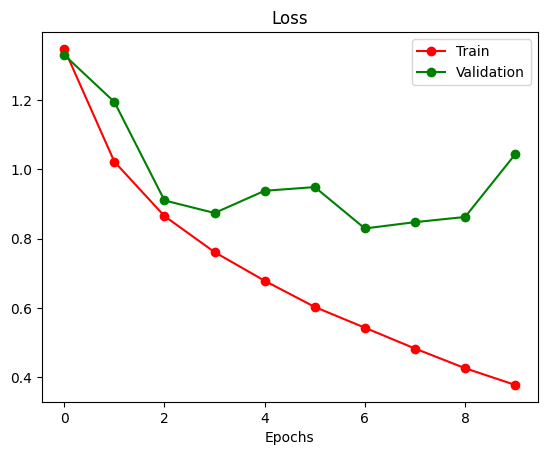

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

lenet_performance = pd.read_csv('data/lenet_performance2.csv')

plt.figure()
plt.plot(lenet_performance["training loss"], "ro-", label="Train")
plt.plot(lenet_performance["eval loss"], "go-", label="Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.savefig("data/lenet_training_curve.png")

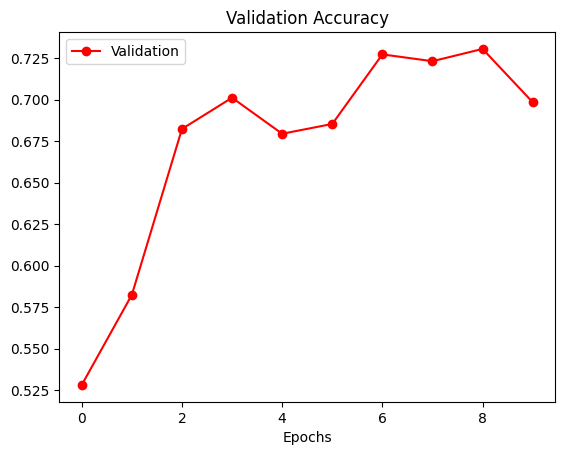

In [ ]:
plt.figure()
plt.plot(lenet_performance["eval accuracy"], "ro-", label="Validation")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.savefig("data/lenet_accuracy.png")

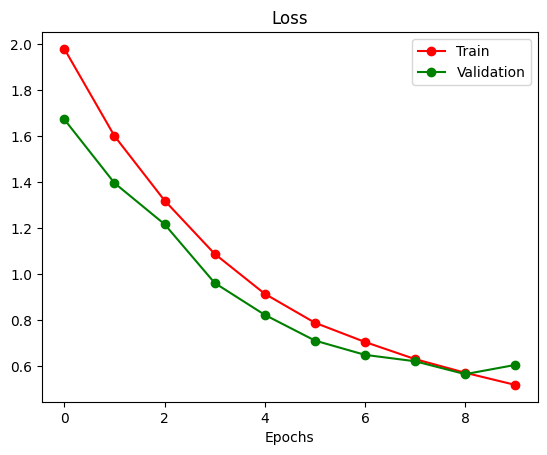

In [ ]:
alexnet_performance = pd.read_csv('data/alexnet_performance2.csv')

plt.figure()
plt.plot(alexnet_performance["training loss"], "ro-", label="Train")
plt.plot(alexnet_performance["eval loss"], "go-", label="Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.savefig("data/alexnet_training_curve.png")

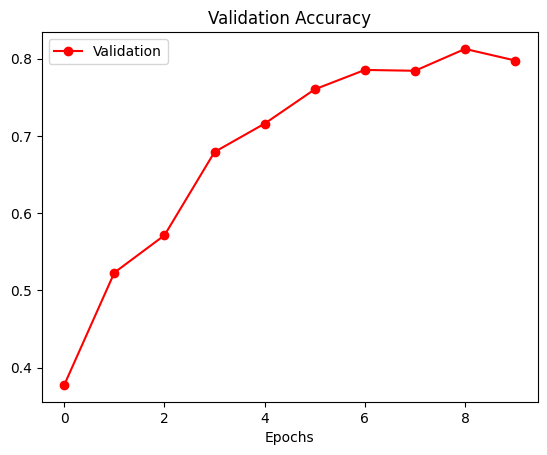

In [ ]:
plt.figure()
plt.plot(alexnet_performance["eval accuracy"], "ro-", label="Validation")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.savefig("data/alexnet_accuracy.png")

## Summary

Summarize the diff

# VGG

## TODO

implement vgg, same as previous two

then do a plotting on accuracy

we expect to see the plotting to oscillate

## Define VGG

In [ ]:
# https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
model = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
# print the layer summary
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

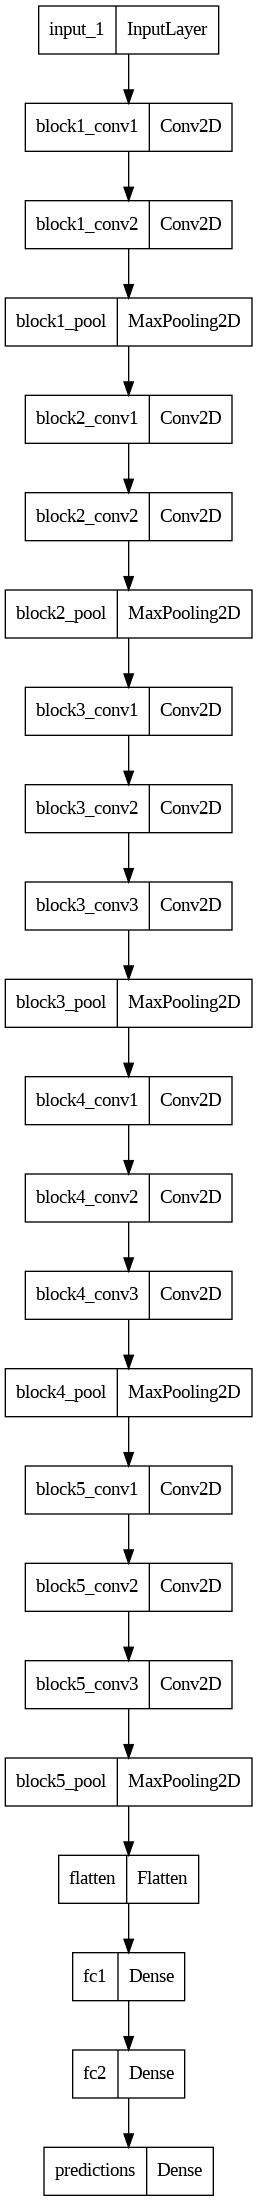

In [ ]:
# print a visual represntation of the layers
plot_model(model, to_file='vgg.png')

## Training VGG

In [ ]:
# train VGG
# get imageNet and train VGG
def compute_accuracy(model, data_loader, device):
    """ Return the evaluation accuracy and loss
    """
    correct_pred, num_examples = 0, 0
    losses = []
    for features, targets in tqdm(data_loader, desc="Evaluation"):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        #targets = get_torch_vars2(features, targets, gpu=True if device==torch.device('cuda') else False)

        out = model(features)
        losses.append(F.cross_entropy(out, targets))
        probas = F.softmax(out, dim=1)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, torch.mean(torch.tensor(losses))
    

def train_vgg16(model):
  """ Return losses and validation accuracies for every epoch (for plotting)
  """

  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
  ])

  train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transform,
                                 download=True)

  test_dataset = datasets.CIFAR10(root='data', 
                                  train=False, 
                                  transform=transform)

  train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            num_workers=2,
                            shuffle=True)

  test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=False)


  start_time = time.time()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

  train_loss = []
  eval_acc = []
  eval_loss = []
  for epoch in range(NUM_EPOCHS):
      
      model.train()
      loss_epoch = []
      for features, targets in tqdm(train_loader, desc="Training"):
          
          # features, targets = get_torch_vars2(features, targets, gpu=True if device==torch.device('cuda') else False)
          features = features.to(DEVICE)
          targets = targets.to(DEVICE)
              
          ### FORWARD AND BACK PROP
          out = model(features)
          probas = F.softmax(out, dim=1)
          loss = F.cross_entropy(out, targets)
          loss_epoch.append(loss)
          optimizer.zero_grad()
          
          loss.backward()
          
          ### UPDATE MODEL PARAMETERS
          optimizer.step()
          
      ### LOGGING
      avg_loss_epoch = torch.mean(torch.tensor(loss_epoch))
      train_loss.append(avg_loss_epoch)
      print('Epoch: %03d/%03d | Train Loss: %.4f' 
              %(epoch+1, NUM_EPOCHS, avg_loss_epoch))

          

      model.eval()
      with torch.set_grad_enabled(False): # save memory during inference
          acc, loss = compute_accuracy(model, test_loader, device=DEVICE)
      eval_acc.append(acc)
      eval_loss.append(loss)
      print('Epoch: %03d/%03d | Eval Acc: %.3f%% | Eval Loss: %.4f' % (
              epoch+1, NUM_EPOCHS, acc, loss))
          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
      
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  # SAVE MODEL
  torch.save(model.state_dict(), 'data/vgg16_model')

  return train_loss, eval_acc, eval_loss

In [ ]:
from torchvision import models

model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.5),
                      nn.Linear(512, NUM_CLASSES))

model = model.to(DEVICE)

train_loss_vgg, eval_acc_vgg, eval_loss_vgg = train_vgg16(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:16<00:00, 33.5MB/s]


Files already downloaded and verified


Training: 100%|██████████| 1563/1563 [11:31<00:00,  2.26it/s]


Epoch: 001/010 | Train Loss: 1.9188


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.05it/s]


Epoch: 001/010 | Eval Acc: 32.920% | Eval Loss: 1.7425
Time elapsed: 12.27 min


Training: 100%|██████████| 1563/1563 [11:29<00:00,  2.27it/s]


Epoch: 002/010 | Train Loss: 1.6361


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.05it/s]


Epoch: 002/010 | Eval Acc: 47.410% | Eval Loss: 1.4305
Time elapsed: 24.50 min


Training: 100%|██████████| 1563/1563 [11:28<00:00,  2.27it/s]


Epoch: 003/010 | Train Loss: 1.4735


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.07it/s]


Epoch: 003/010 | Eval Acc: 53.300% | Eval Loss: 1.2935
Time elapsed: 36.72 min


Training: 100%|██████████| 1563/1563 [11:27<00:00,  2.27it/s]


Epoch: 004/010 | Train Loss: 1.3650


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.06it/s]


Epoch: 004/010 | Eval Acc: 53.690% | Eval Loss: 1.3016
Time elapsed: 48.92 min


Training: 100%|██████████| 1563/1563 [11:27<00:00,  2.27it/s]


Epoch: 005/010 | Train Loss: 1.3041


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.06it/s]


Epoch: 005/010 | Eval Acc: 56.670% | Eval Loss: 1.2174
Time elapsed: 61.12 min


Training: 100%|██████████| 1563/1563 [11:27<00:00,  2.27it/s]


Epoch: 006/010 | Train Loss: 1.2403


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.07it/s]


Epoch: 006/010 | Eval Acc: 58.180% | Eval Loss: 1.2048
Time elapsed: 73.32 min


Training: 100%|██████████| 1563/1563 [11:27<00:00,  2.27it/s]


Epoch: 007/010 | Train Loss: 1.2264


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.07it/s]


Epoch: 007/010 | Eval Acc: 59.030% | Eval Loss: 1.1835
Time elapsed: 85.52 min


Training: 100%|██████████| 1563/1563 [11:27<00:00,  2.27it/s]


Epoch: 008/010 | Train Loss: 1.1828


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.08it/s]


Epoch: 008/010 | Eval Acc: 60.670% | Eval Loss: 1.0978
Time elapsed: 97.71 min


Training: 100%|██████████| 1563/1563 [11:26<00:00,  2.28it/s]


Epoch: 009/010 | Train Loss: 1.1618


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.06it/s]


Epoch: 009/010 | Eval Acc: 61.190% | Eval Loss: 1.1296
Time elapsed: 109.90 min


Training: 100%|██████████| 1563/1563 [11:26<00:00,  2.28it/s]


Epoch: 010/010 | Train Loss: 1.1302


Evaluation: 100%|██████████| 313/313 [00:44<00:00,  7.08it/s]


Epoch: 010/010 | Eval Acc: 60.460% | Eval Loss: 1.1398
Time elapsed: 122.08 min
Total Training Time: 122.08 min


In [ ]:
pd.DataFrame(format_result(train_loss_vgg, eval_acc_vgg, eval_loss_vgg)).to_csv('data/vgg_performance.csv')

## Plotting

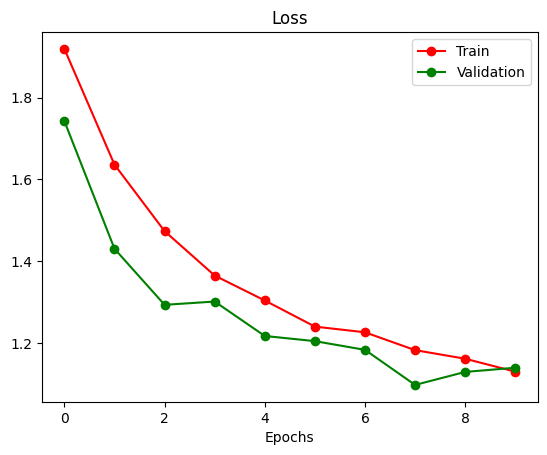

In [ ]:
vgg_performance = pd.read_csv('data/vgg_performance.csv')

plt.figure()
plt.plot(vgg_performance["training loss"], "ro-", label="Train")
plt.plot(vgg_performance["eval loss"], "go-", label="Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.savefig("data/vgg_training_curve.png")

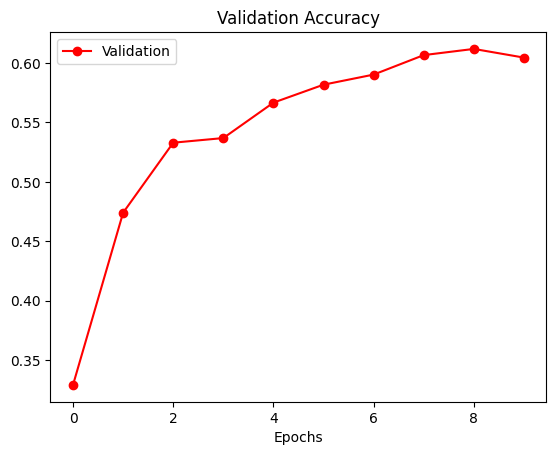

In [ ]:
plt.figure()
plt.plot(vgg_performance["eval accuracy"], "ro-", label="Validation")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.savefig("data/vgg_accuracy.png")

# ResNet

## TODO

IMPLEMENT ResNet, same as previous two

plot and we expect to see a very smooth curve that converge to a relatively good performance.

## Define ResNet

In [ ]:
# Residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


## Training ResNet

In [ ]:
# Train ResNet
def compute_accuracy(model, data_loader, device):
    """ Return the evaluation accuracy and loss
    """
    correct_pred, num_examples = 0, 0
    losses = []
    for features, targets in tqdm(data_loader, desc="Evaluation"):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        #targets = get_torch_vars2(features, targets, gpu=True if device==torch.device('cuda') else False)

        out = model(features)
        losses.append(F.cross_entropy(out, targets))
        probas = F.softmax(out, dim=1)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, torch.mean(torch.tensor(losses))
    

def train_resnet(model):
  """ Return losses and validation accuracies for every epoch (for plotting)
  """

  # Image preprocessing modules
  transform = transforms.Compose([
      transforms.Pad(4),
      transforms.RandomHorizontalFlip(),
      transforms.RandomCrop(32),
      transforms.ToTensor()])

  train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transform,
                                 download=True)

  test_dataset = datasets.CIFAR10(root='data', 
                                  train=False, 
                                  transform=transform)

  train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=batch_size, 
                            num_workers=2,
                            shuffle=True)

  test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=False)


  start_time = time.time()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

  train_loss = []
  eval_acc = []
  eval_loss = []
  for epoch in range(NUM_EPOCHS):
      
      model.train()
      loss_epoch = []
      for features, targets in tqdm(train_loader, desc="Training"):
          
          # features, targets = get_torch_vars2(features, targets, gpu=True if device==torch.device('cuda') else False)
          features = features.to(DEVICE)
          targets = targets.to(DEVICE)
              
          ### FORWARD AND BACK PROP
          out = model(features)
          probas = F.softmax(out, dim=1)
          loss = F.cross_entropy(out, targets)
          loss_epoch.append(loss)
          optimizer.zero_grad()
          
          loss.backward()
          
          ### UPDATE MODEL PARAMETERS
          optimizer.step()
          
      ### LOGGING
      avg_loss_epoch = torch.mean(torch.tensor(loss_epoch))
      train_loss.append(avg_loss_epoch)
      print('Epoch: %03d/%03d | Train Loss: %.4f' 
              %(epoch+1, NUM_EPOCHS, avg_loss_epoch))

          

      model.eval()
      with torch.set_grad_enabled(False): # save memory during inference
          acc, loss = compute_accuracy(model, test_loader, device=DEVICE)
      eval_acc.append(acc)
      eval_loss.append(loss)
      print('Epoch: %03d/%03d | Eval Acc: %.3f%% | Eval Loss: %.4f' % (
              epoch+1, NUM_EPOCHS, acc, loss))
          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
      
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  # SAVE MODEL
  torch.save(model.state_dict(), 'data/resnet_model')

  return train_loss, eval_acc, eval_loss

In [ ]:
resnet_model = ResNet(Bottleneck, [3, 4, 6, 3]).to(device)
train_loss_resnet, eval_acc_resnet, eval_loss_resnet = train_resnet(resnet_model)

Files already downloaded and verified


Training: 100%|██████████| 1563/1563 [02:55<00:00,  8.89it/s]


Epoch: 001/010 | Train Loss: 1.6529


Evaluation: 100%|██████████| 313/313 [00:10<00:00, 28.79it/s]


Epoch: 001/010 | Eval Acc: 48.890% | Eval Loss: 1.4723
Time elapsed: 3.11 min


Training: 100%|██████████| 1563/1563 [02:55<00:00,  8.89it/s]


Epoch: 002/010 | Train Loss: 1.1935


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 32.43it/s]


Epoch: 002/010 | Eval Acc: 59.060% | Eval Loss: 1.2106
Time elapsed: 6.21 min


Training: 100%|██████████| 1563/1563 [02:55<00:00,  8.91it/s]


Epoch: 003/010 | Train Loss: 1.0088


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 31.75it/s]


Epoch: 003/010 | Eval Acc: 68.860% | Eval Loss: 0.8816
Time elapsed: 9.31 min


Training: 100%|██████████| 1563/1563 [02:54<00:00,  8.98it/s]


Epoch: 004/010 | Train Loss: 0.8648


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 33.11it/s]


Epoch: 004/010 | Eval Acc: 72.890% | Eval Loss: 0.7832
Time elapsed: 12.37 min


Training: 100%|██████████| 1563/1563 [02:53<00:00,  9.00it/s]


Epoch: 005/010 | Train Loss: 0.7531


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 32.15it/s]


Epoch: 005/010 | Eval Acc: 74.070% | Eval Loss: 0.7604
Time elapsed: 15.43 min


Training: 100%|██████████| 1563/1563 [02:53<00:00,  9.00it/s]


Epoch: 006/010 | Train Loss: 0.6726


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 33.34it/s]


Epoch: 006/010 | Eval Acc: 77.430% | Eval Loss: 0.6534
Time elapsed: 18.49 min


Training: 100%|██████████| 1563/1563 [02:53<00:00,  9.00it/s]


Epoch: 007/010 | Train Loss: 0.6030


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 33.18it/s]


Epoch: 007/010 | Eval Acc: 78.790% | Eval Loss: 0.6038
Time elapsed: 21.55 min


Training: 100%|██████████| 1563/1563 [02:53<00:00,  9.01it/s]


Epoch: 008/010 | Train Loss: 0.5485


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 33.40it/s]


Epoch: 008/010 | Eval Acc: 80.660% | Eval Loss: 0.5616
Time elapsed: 24.60 min


Training: 100%|██████████| 1563/1563 [02:53<00:00,  9.01it/s]


Epoch: 009/010 | Train Loss: 0.5038


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 33.32it/s]


Epoch: 009/010 | Eval Acc: 82.570% | Eval Loss: 0.5254
Time elapsed: 27.65 min


Training: 100%|██████████| 1563/1563 [02:53<00:00,  9.01it/s]


Epoch: 010/010 | Train Loss: 0.4545


Evaluation: 100%|██████████| 313/313 [00:09<00:00, 33.28it/s]


Epoch: 010/010 | Eval Acc: 78.400% | Eval Loss: 0.6333
Time elapsed: 30.70 min
Total Training Time: 30.70 min


In [ ]:
pd.DataFrame(format_result(train_loss_resnet, eval_acc_resnet, eval_loss_resnet)).to_csv('data/resnet_performance.csv')

## Plotting

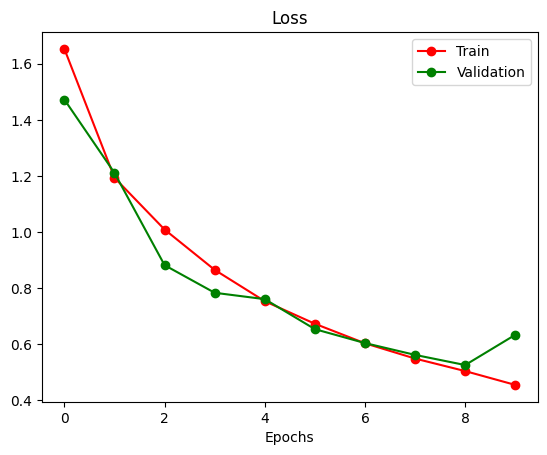

In [ ]:
resnet_performance = pd.read_csv('data/resnet_performance.csv')

plt.figure()
plt.plot(resnet_performance["training loss"], "ro-", label="Train")
plt.plot(resnet_performance["eval loss"], "go-", label="Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.savefig("data/resnet_training_curve.png")

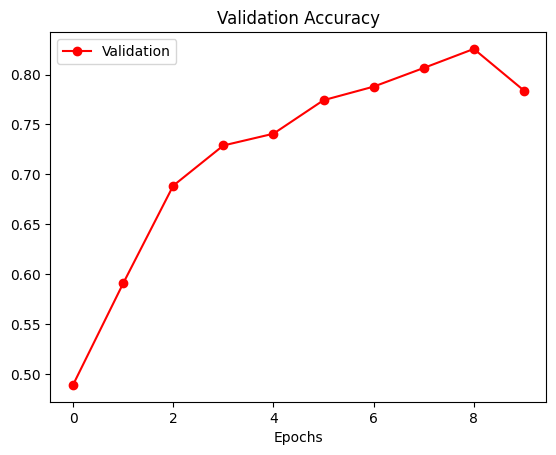

In [ ]:
plt.figure()
plt.plot(resnet_performance["eval accuracy"], "ro-", label="Validation")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.savefig("data/resnet_accuracy.png")

# Conclusion



## Compare the plotting charts

In [ ]:
# To get plotting, run from this cell, no need to run above cells

%mkdir -p /content/csc413/final/data
%cd /content/csc413/final

# Import matplotlib for plotting
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

lenet_performance = pd.read_csv('data/lenet_performance.csv').iloc[: , 1:]
alexnet_performance = pd.read_csv('data/alexnet_performance.csv').iloc[: , 1:]
vgg_performance = pd.read_csv('data/vgg_performance.csv')
resnet_performance = pd.read_csv('data/resnet_performance.csv')

/content/csc413/final


In [ ]:
# [0] = train loss, [1] = acc, [2] = eval loss
lenet_performance.head()


,0,1,2,3,4,5,6,7,8,9
0,tensor(1.3456),tensor(1.0096),tensor(0.8519),tensor(0.7517),tensor(0.6680),tensor(0.5953),tensor(0.5312),tensor(0.4713),tensor(0.4166),tensor(0.3690)
1,"tensor(53.0500, device='cuda:0')","tensor(61.4600, device='cuda:0')","tensor(68.1400, device='cuda:0')","tensor(70.5700, device='cuda:0')","tensor(69.4800, device='cuda:0')","tensor(69.9300, device='cuda:0')","tensor(71.7700, device='cuda:0')","tensor(72.0200, device='cuda:0')","tensor(70.1700, device='cuda:0')","tensor(73.2700, device='cuda:0')"
2,tensor(1.3371),tensor(1.0870),tensor(0.9411),tensor(0.8531),tensor(0.8756),tensor(0.9307),tensor(0.8679),tensor(0.9012),tensor(1.0120),tensor(0.9116)


In [ ]:
lenet_performance = lenet_performance.applymap(lambda x : float(x[x.find('(')+1: x.find(',')]))
lenet_performance.head()

,0,1,2,3,4,5,6,7,8,9
0,1.3456,1.0096,0.8519,0.7517,0.6680,0.5953,0.5312,0.4713,0.4166,0.3690
1,53.0500,61.4600,68.1400,70.5700,69.4800,69.9300,71.7700,72.0200,70.1700,73.2700
2,1.3371,1.0870,0.9411,0.8531,0.8756,0.9307,0.8679,0.9012,1.0120,0.9116


In [ ]:
alexnet_performance = alexnet_performance.applymap(lambda x : float(x[x.find('(')+1: x.find(',')]))
alexnet_performance.head()

,0,1,2,3,4,5,6,7,8,9
0,1.9802,1.6009,1.3200,1.0878,0.9139,0.7879,0.7042,0.6295,0.5702,0.5172
1,37.7500,52.2900,57.1200,67.9100,71.5800,76.0200,78.5300,78.4200,81.2500,79.7500
2,1.6730,1.3962,1.2168,0.9612,0.8223,0.7104,0.6481,0.6202,0.5642,0.6043


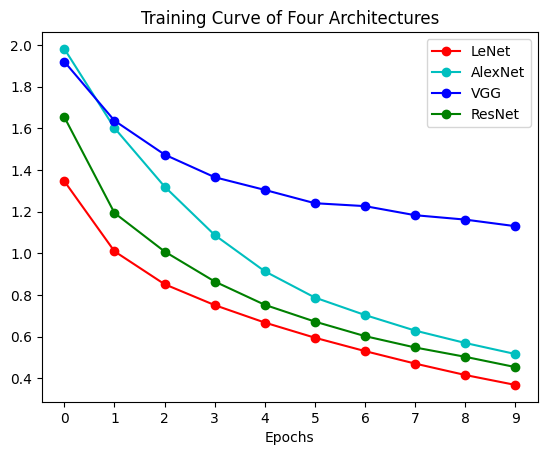

In [ ]:
# plot train loss
plt.figure()
plt.plot(lenet_performance.iloc[0,:], "ro-", label="LeNet")
plt.plot(alexnet_performance.iloc[0,:], "co-", label="AlexNet")
plt.plot(vgg_performance["training loss"], "bo-", label="VGG")
plt.plot(resnet_performance["training loss"], "go-", label="ResNet")
plt.legend()
plt.title("Training Curve of Four Architectures")
plt.xlabel("Epochs")
plt.savefig("data/all_training_curve.png")

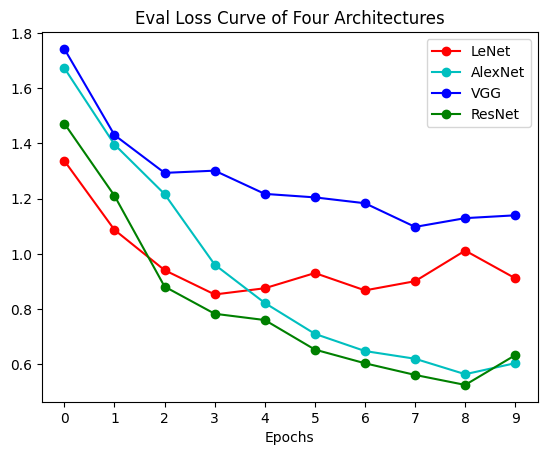

In [ ]:
# plot eval loss
plt.figure()
plt.plot(lenet_performance.iloc[2,:], "ro-", label="LeNet")
plt.plot(alexnet_performance.iloc[2,:], "co-", label="AlexNet")
plt.plot(vgg_performance["eval loss"], "bo-", label="VGG")
plt.plot(resnet_performance["eval loss"], "go-", label="ResNet")
plt.legend()
plt.title("Eval Loss Curve of Four Architectures")
plt.xlabel("Epochs")
plt.savefig("data/all_eval_curve.png")

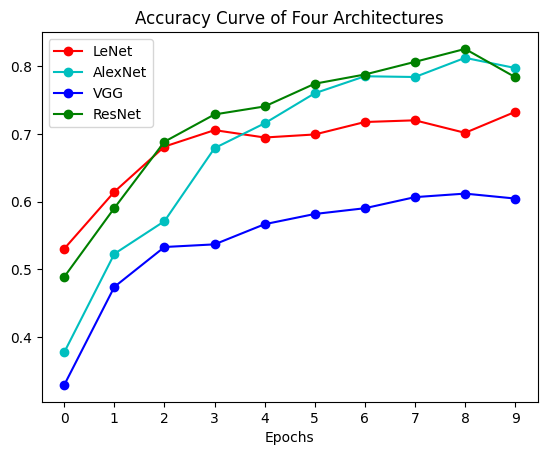

In [ ]:
# plot accuracy

# Note that lenet/alexnet acc was out of 100, while vgg and resnet was out of 1
plt.figure()
plt.plot(lenet_performance.apply(lambda x: x/100, axis = 0).iloc[1,:], "ro-", label="LeNet")
plt.plot(alexnet_performance.apply(lambda x: x/100, axis = 0).iloc[1,:], "co-", label="AlexNet")
plt.plot(vgg_performance["eval accuracy"], "bo-", label="VGG")
plt.plot(resnet_performance["eval accuracy"], "go-", label="ResNet")
plt.legend()
plt.title("Accuracy Curve of Four Architectures")
plt.xlabel("Epochs")
plt.savefig("data/all_accuracy_curve.png")

## Summary


**Note that** we used pretrained model for VGG but constructed ResNet ourselves.

# Reference:

 -- add paper for each architecture

 -- add sample paper on performance

 -- one text cell for each

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://www.researchgate.net/figure/Classical-CNN-Architectures-LeNet-and-AlexNet-used-to-outperform-the-state-of-the-art_fig1_351333148

https://www.researchgate.net/figure/Performance-comparison-of-VGGNet-ResNet-LeNet-and-AlexNet-architectures_tbl2_353473901

https://openreview.net/pdf?id=rYt0p0Um9r